<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-09-20' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20158327" #@param {type:"string"}
Student_full_name = "Xiaoming Zhang" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [6]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [7]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

In [8]:
housePath = ''
is_COLAB = 'google.colab' in str(get_ipython())
if is_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    housePath = '/content/drive/MyDrive/Colab Notebooks/Data/house/'
else:
    housePath = ''

In [9]:
# file names
train_file_name = 'house_train.csv'
test_file_name = 'house_test.csv'
true_price_file_name = 'true_price.csv'

# training dataset: 
training_file = housePath + train_file_name

# test dataset: 
testing_file = housePath + test_file_name

# true price dataset: 
cost_file = housePath + true_price_file_name

### Train Data Set

In [10]:
# load train dataset
df_train = pd.read_csv(training_file)

# list the column to move the column price to the end
df_train = df_train[['ad_id', 'area', 'bathrooms', 'beds', 'ber_classification', 'county',
       'description_block', 'environment', 'facility', 'features', 'latitude',
       'longitude', 'no_of_units', 'property_category',
       'property_type', 'surface', 'price']]

# show first data frame rows 
df_train.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface,price
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,new_development_parent,NaN,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,new_development_parent,NaN,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,new_development_parent,NaN,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,new_development_parent,NaN,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,new_development_parent,NaN,NaN,NaN


In [11]:
# Generate descriptive statistics
df_train.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,surface,price
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2431.000000,2.892000e+03
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,318.851787,5.323536e+05
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,4389.423136,5.678148e+05
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,3.400000,1.999500e+04
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,74.100000,2.800000e+05
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,100.000000,3.800000e+05
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,142.000000,5.750000e+05
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,182108.539008,9.995000e+06


### Test Data Set

In [12]:
# load test dataset
df_test = pd.read_csv(testing_file)

# show first data frame rows
df_test.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


In [13]:
# Generate descriptive statistics
df_test.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,surface
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,0.0,500.000000
mean,1.231695e+07,1.994000,2.930000,53.356034,-6.247842,NaN,156.007671
std,1.485832e+05,1.106532,1.191612,0.081905,0.088552,NaN,344.497362
min,1.130615e+07,0.000000,0.000000,53.221348,-6.496987,NaN,33.500000
25%,1.228617e+07,1.000000,2.000000,53.297373,-6.296404,NaN,72.375000
50%,1.237964e+07,2.000000,3.000000,53.339547,-6.243572,NaN,98.000000
75%,1.240544e+07,3.000000,4.000000,53.381650,-6.185055,NaN,138.935000
max,1.242809e+07,8.000000,7.000000,53.619775,-6.064874,NaN,5746.536120


### Expected Cost dataset

In [14]:
# load train dataset
df_cost = pd.read_csv(cost_file)

# show first data frame rows
df_cost.head()

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [15]:
# Generate descriptive statistics
df_cost.describe()

,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


In [16]:
# show data set shape
df_train.shape

(2982, 17)

In [17]:
# show data set shape
df_test.shape

(500, 16)

In [18]:
# show data set shape
df_cost.shape

(500, 2)

In [19]:
# X_train is from train data set except column price
X_train = df_train.loc[:, df_train.columns != 'price']

# X_test is from test data set
X_test = df_test

# y_train is form train data set with column price
y_train = df_train[['price']]

# y_test is from true price with column Expected
y_test =  df_cost[['Expected']]

In [20]:
X_train

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,new_development_parent,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2977,12428232,Ballsbridge,2.0,2.0,C3,Dublin,Sherry FitzGerald are delighted to present Apa...,prod,NaN,Prime Location\nManagement Co: Core Property M...,53.338738,-6.237199,NaN,sale,apartment,56.0
2978,12428240,Rialto,1.0,3.0,B2,Dublin,Property Team Patrick Moran is delighted to pr...,prod,NaN,Totally refurbished to the highest standard. \...,53.335793,-6.294268,NaN,sale,terraced,101.0
2979,12428247,Smithfield,1.0,2.0,C3,Dublin,Earnest estate agents are delighted to present...,prod,Wired for Cable Television,OVERLOOKING THE RIVER LIFFEY \n3RD FLOOR APART...,53.346098,-6.276856,NaN,sale,apartment,55.6
2980,12428254,Foxrock,2.0,3.0,C3,Dublin,Janet Carroll Estate Agents are pleased to pre...,prod,"Parking,Gas Fired Central Heating",None,53.273518,-6.178500,NaN,sale,end-of-terrace,97.0


In [21]:
X_test

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,12369815,Ringsend,1.0,2.0,NaN,Dublin,***SUPERB LOCATION / PRIVATE PARKING OPTION AV...,prod,NaN,Adjacent to Grand Canal Dock\nClose to a host ...,53.342207,-6.226101,NaN,sale,apartment,65.0
496,12416011,Cabinteely,3.0,5.0,E1,Dublin,"OPEN VIEWING SATURDAY 7TH MARCH, 10.00AM - 10....",prod,"Parking,Alarm,Oil Fired Central Heating",Excellently presented 5 bedroom family home\nE...,53.261475,-6.147720,NaN,sale,detached,191.3
497,12232222,Artane,1.0,3.0,G,Dublin,Sherry FitzGerald is delighted to present to t...,prod,NaN,Detached Family Home\nOnly One Owner\nMature C...,53.391619,-6.205157,NaN,sale,detached,105.0
498,11905630,Clontarf,2.0,4.0,E2,Dublin,Modernised yet still in touch with it's period...,prod,"Parking,Gas Fired Central Heating,Alarm,Wired ...",Stunning coastal views.\nExcellent condition t...,53.360578,-6.183701,NaN,sale,end-of-terrace,130.0


In [22]:
y_train

,price
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
2977,415000.0
2978,485000.0
2979,299000.0
2980,495000.0


In [23]:
y_test

,Expected
0,875000.0
1,355000.0
2,440000.0
3,425000.0
4,265000.0
...,...
495,345000.0
496,775000.0
497,360000.0
498,925000.0


# PIECEWISE REGRESSION

## Full Model

In [24]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['beds', 'latitude', 'longitude', 'surface','price']
# dropna: remove missing values
df_subset_train = df_train[featrain].dropna(axis=0)

featest = ['beds', 'latitude', 'longitude', 'surface']
df_subset_test  =  df_test[featest].dropna(axis=0)

# cost
df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

In [25]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [26]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost['Expected'].values

In [27]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [28]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 2,523.9


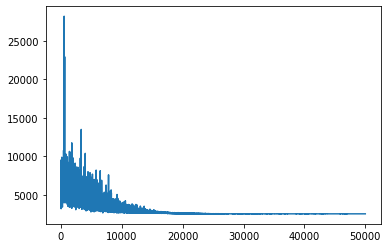

In [29]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [ ]:
# samples from the posterior
posterior = approximation.sample(5000)

In [ ]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

## Clustering

### Full Model

In [ ]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[0,1]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [ ]:
np.max(ys_train)

### Clusters

In [ ]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

In [ ]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

In [ ]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [ ]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [ ]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [ ]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

In [ ]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

In [ ]:
with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

In [ ]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

In [ ]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

In [ ]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

In [ ]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

##Simulations

### Only Cluster 0

In [ ]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

In [ ]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

In [ ]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 3

In [ ]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

In [ ]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [ ]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

### PPC on the Test set



In [ ]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY